In [26]:
# Import Packages

import torch
import sklearn

import numpy as np
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset, random_split
import os
import torch
from torchvision import transforms
import torchvision.datasets as datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.models import resnet50, ResNet50_Weights
import matplotlib.pyplot as plt
import torch.backends.cudnn as cudnn

#from sklearn.preprocessing import normalize


# Allows torch to use gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

'''
# Get Data Transforms for ReseNet50
train_transforms = ResNet50_Weights.DEFAULT.transforms()

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


# # Define data transforms
# transform = transforms.Compose([
#       transforms.Resize((224,224)),
#       transforms.ToTensor()])



# Import images from Oxford Pet Dataset
if not os.path.exists('./data-train'):
  #oxford_train_data = datasets.OxfordIIITPet(root = './data-train', split = "trainval", transform = preprocess, download = True)
  #oxford_test_data = datasets.OxfordIIITPet(root = './data-test', split = "test", transform = preprocess, download = True)
  CIFAR_train_data = datasets.CIFAR10(root = './data-train', train = True, transform = preprocess, download = True)
  CIFAR_test_data = datasets.CIFAR10(root = './data-test', train = False, transform = preprocess, download = True)

else:
  #oxford_train_data = datasets.OxfordIIITPet(root = './data-train', split = "trainval", transform = preprocess, download = False)
  #oxford_test_data = datasets.OxfordIIITPet(root = './data-test', split = "test", transform = preprocess, download = False)
  CIFAR_train_data = datasets.CIFAR10(root = './data-train', train = True, transform = preprocess, download = True)
  CIFAR_test_data = datasets.CIFAR10(root = './data-test', train = False, transform = preprocess, download = True)
  print("Not Downloaded")

# Implement Data Loader
batch = 16
workers = 8
data_train_loader = DataLoader(CIFAR_train_data,
                          batch_size=batch,
                          shuffle=True,
                          num_workers=workers)

data_test_loader = DataLoader(CIFAR_test_data,
                          batch_size=batch,
                          shuffle=True,
                          num_workers=workers)

'''

batch = 16
workers = 8

# Define the data transformation
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Get the current working directory (the directory where your script is located)
current_dir = os.getcwd()

# Set the relative path to your data root directory
relative_data_root = 'dataset_onefinger/'

# Construct the absolute path to the data root
data_root = os.path.join(current_dir, relative_data_root)

# Create the ImageFolder dataset
dataset = datasets.ImageFolder(root=data_root, transform=transform)

# Define the size of your test set
test_size = int(200)  # Adjust the split ratio as needed

# Split the dataset into training and test sets
train_size = len(dataset) - test_size
train_set, test_set = random_split(dataset, [train_size, test_size])

# Create data loaders
train_loader = DataLoader(train_set, batch_size=batch, num_workers=workers, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch,num_workers=workers, shuffle=False)



In [4]:


# Generate embeddings

def generate_embeddings(oxford_data, fileName):
    """
    Transform, resize and normalize the images and then use a pretrained model to extract
    the embeddings.
    """




    # TODO: define a model for extraction of the embeddings (Hint: load a pretrained model,
    #  more info here: https://pytorch.org/vision/stable/models.html)



    embeddings = []
    embedding_size = 2048 #CHANGED FROM 4096

    # pick your model
    num_images = len(oxford_data)

    embeddings = np.zeros((num_images, embedding_size))

    # TODO: Use the model to extract the embeddings. Hint: remove the last layers of the
    # model to access the embeddings the model generates.



    resNetmodel = resnet50(pretrained = True)
    resNetmodel.to(device)
    resNetmodel = nn.Sequential(*(list(resNetmodel.children())[:-1]))
    resNetmodel.eval()
    i = 0
    ran = False
    length_datset = len(oxford_data)
    print(length_datset)
    k = 0
    for [X, y] in oxford_data:
        print(i)
        k = k+1
        X = torch.tensor(X).to(device)
        y = torch.tensor(y).to(device)
        
        '''
        if not ran:

            # Display Images
            convert_tensor = transforms.Grayscale()
            img_g = convert_tensor(X[:3,:,:].cpu())
            print('Grayscale Image Dimensions', img_g.shape)

            # display grayscale image
            plt.imshow(img_g.permute(1, 2, 0), cmap='gray')
            plt.show()



            output = model(X)
            print(output)
            print(output.shape)
            ran = True
        '''

        X = X.unsqueeze(0)
        output = resNetmodel(X)
        #print(len(output.detach().numpy().flatten()))
        #embeddings[i] = output.detach().numpy().flatten()

        for j in range(0,batch):
            if j >= len(output) or batch*i+j > num_images:
                break
            embeddings[batch*i+j] = output[j].detach().cpu().numpy().squeeze()


        #print(len(embeddings[i]))

        i += 1
    np.save('dataset/embeddings_' + fileName + '.npy', embeddings)




In [5]:



class SimpleClassifier(nn.Module):
    def __init__(self, embedding_dim, num_classes):
        super(SimpleClassifier, self).__init__()

        # Define layers
        self.fc1 = nn.Linear(embedding_dim, 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.dropout1 = nn.Dropout(0.5)  # Increased dropout a bit for regularization

        self.fc2 = nn.Linear(1024, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.dropout2 = nn.Dropout(0.5)

        self.fc3 = nn.Linear(512, 256)
        self.bn3 = nn.BatchNorm1d(256)
        self.dropout3 = nn.Dropout(0.5)

        self.fc4 = nn.Linear(256, 128)
        self.bn4 = nn.BatchNorm1d(128)
        self.dropout4 = nn.Dropout(0.5)

        self.fc5 = nn.Linear(128, num_classes)  # This directly predicts the class

    def forward(self, x):
        x = x.to(device=self.fc1.weight.device)

        # Block 1
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout1(x)

        # Block 2
        x = self.fc2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout2(x)

        # Block 3
        x = self.fc3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.dropout3(x)

        # Block 4
        x = self.fc4(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = self.dropout4(x)

        # Output layer
        x = self.fc5(x)  # No activation here as we're using CrossEntropyLoss

        return x
    
    
    
    '''
    """
    The model class, which defines our classifier.
    """
    def __init__(self, embedding_dim, num_classes):
        """
        The constructor of the model.
        """
        
        super().__init__()
        
        self.fc1 = nn.Linear(embedding_dim, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.3)

        self.bn = nn.BatchNorm1d(1024)

    def forward(self, x):
        """
        The forward pass of the model.

        input: x: torch.Tensor, the input to the model

        output: x: torch.Tensor, the output of the model
        """
        
        x = x.to(device=self.fc1.weight.device)
        x = self.fc1(x)
        x = self.bn(x)
        x = torch.relu(x)
        #x = self.dropout(x)
        x = self.fc2(x)
        x = torch.relu(x)
        #x = self.dropout(x)
        x = self.fc3(x)
        x = torch.relu(x)
        x = self.fc4(x)
        x = torch.relu(x)
        x = self.fc5(x)
        #x = torch.softmax(x, dim=1) # Don't want to use becuase already included in cross entropy loss
       
        return x
    '''
    
    
    '''
    def __init__(self, embedding_dim, num_classes):
        super(SimpleClassifier, self).__init__()
        self.fc1 = nn.Linear(embedding_dim, 128)  # depending on the size of your embeddings
        self.fc2 = nn.Linear(128, num_classes)    # num_classes is the number of your target labels

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    '''



In [17]:
def train_model(train_loader, model, NUM_EPOCHS):

  model.train()
  model.to(device)
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
  true_labels = []
  predicted_labels = []
  losses = []
  print("before epoch")
  # Train the model
  for epoch in range(NUM_EPOCHS):  # loop over the dataset multiple times
      #i = 0
      for inputs, labels in train_loader:
          #print(str(i) + " Out of " + str(len(train_loader)))
          #i+=1
          # Make sure all values are on cuda
          inputs, labels = inputs.to(device), labels.to(device)
          
          # zero the parameter gradients
          optimizer.zero_grad()
          
          #labels_adj = labels - 1
          #print(labels)
          # forward + backward + optimize
          outputs = model(inputs)
          #print(labels)
          loss = criterion(outputs, labels)
          loss = loss.to("cpu")
          losses.append(loss.detach().numpy())
          loss.backward()
          optimizer.step()
        
          inputs, labels, outputs = inputs.to("cpu"), labels.to("cpu"), outputs.to("cpu")
          # Setup values for confusion matrix
          true_labels.extend(labels)
          predicted_labels.extend(outputs.detach().numpy() )
          #true_labels = true_labels.cpu()
          #predicted_labels = predicted_labels.cpu()
          #losses = predicted_labels.cpu()
          

      # print statistics or validate on your test set
      print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, NUM_EPOCHS, loss.item()))
  
  np.save('dataset/true_labels.npy', true_labels)
  np.save('dataset/predicted_labels.npy', predicted_labels)
  np.save('dataset/predicted_losses.npy', losses)
  print('Finished Training')

In [7]:
def create_loader_from_np(X, y = None, batch_size=16, shuffle=True, num_workers = 8):
    """
    Create a torch.utils.data.DataLoader object from numpy arrays containing the data.

    input: X: numpy array, the features
           y: numpy array, the labels

    output: loader: torch.data.util.DataLoader, the object containing the data
    """

    dataset = TensorDataset(torch.from_numpy(X).type(torch.float),
                            torch.from_numpy(y).type(torch.long))

    loader = DataLoader(dataset=dataset,
                        batch_size=batch_size,
                        shuffle=shuffle,
                        pin_memory=True, num_workers=num_workers)
    return loader

In [8]:
def get_data(data_loader, train=True):

    embeddings = []
    if train:
      embeddings = np.load('dataset/embeddings_train.npy')
    else: 
      embeddings = np.load('dataset/embeddings_test.npy')
    # TODO: Normalize the embeddings across the dataset
    print("Got Here")
    #embeddings_normalized = normalize(embeddings)
    # Calculate the mean and standard deviation
    mean = np.mean(embeddings, axis=0)
    std = np.std(embeddings, axis=0)

    # Normalize the embeddings
    #embeddings_normalized = (embeddings - mean) / std

    embeddings_normalized = torch.nn.functional.normalize(embeddings, p=2, dim=1)


    X = embeddings_normalized
    y = []
    for _, labels in data_loader:  # We're not using the data, so we can disregard it with _
      y.append(labels)

    X = np.vstack(X)
    y = np.hstack(y)
    return X, y

In [22]:

'''
def test_model(test_loader, model):
  # code to evaluate model on test data
  model.eval()  # Set the model to evaluation mode
  with torch.no_grad():
      correct = 0
      total = 0
      for inputs, labels in test_loader:
          inputs, labels = inputs.to(device), labels.to(device)
          outputs = model(inputs)
          _, predicted = torch.max(outputs.data, 1)
          #print(predicted)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

      print('Accuracy: {}%'.format(100 * correct / total))
'''

from sklearn.metrics import confusion_matrix

def test_model(test_loader, model):
    model.eval()  # Set the model to evaluation mode
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            print(labels)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    confusion_mat = confusion_matrix(all_labels, all_predictions)
    print('Confusion Matrix:')
    print(confusion_mat)

    accuracy = (confusion_mat.diagonal().sum() / confusion_mat.sum()) * 100
    print('Accuracy: {}%'.format(accuracy))
    return confusion_mat

In [9]:
# Run Main Section
import os


if __name__ == '__main__':
  NUM_EPOCHS = 5

  # generate embedding for each image in the dataset
  if(os.path.exists('dataset/embeddings_train.npy') == False):
      generate_embeddings(CIFAR_train_data, "train")
  if(os.path.exists('dataset/embeddings_test.npy') == False):
      generate_embeddings(CIFAR_test_data, "test")




  X, y = get_data(data_train_loader, train=True)
  print("Got From TRAIN")


  X_test, y_test = get_data(data_test_loader, train = False)
  print("Got From TEST")
  print(X_test.shape)
  print(y_test.shape)



  

Got Here


AttributeError: 'numpy.ndarray' object has no attribute 'norm'

In [23]:

# Model for Transfer Learning

if __name__ == '__main__':  
  
  # Initialize the model
  model = SimpleClassifier(embedding_dim=2048, num_classes=10)
  
  NUM_EPOCHS = 5
  # Create data loaders for the training and testing data
  train_loader = create_loader_from_np(X, y,  batch_size=32)


  print("Created Loader from NP Train")
  test_loader = create_loader_from_np(X_test,y_test, batch_size=32)

  # Train Model
  train_model(train_loader, model, NUM_EPOCHS)
  # Test Model
  test_model(test_loader, model)

NameError: name 'SimpleClassifier' is not defined

In [27]:
# Non-Transfer Learning Model
NUM_EPOCHS = 5
resNetNotTrained = resnet50(pretrained = False)
resNetNotTrained.to(device)
resNetNotTrained.eval()

# Run in parallel 
if device == 'cuda':
    resNetNotTrained = torch.nn.DataParallel(resNetNotTrained)
    cudnn.benchmark = True

print("got here")
# Train Model
train_model(train_loader, resNetNotTrained, NUM_EPOCHS)
# Test Model
conf_matrix = test_model(test_loader, resNetNotTrained)

c:\Users\walte\AppData\Local\Programs\Python\Python38\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\walte\AppData\Local\Programs\Python\Python38\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


got here
before epoch
Epoch [1/5], Loss: 1.5293
Epoch [2/5], Loss: 0.0013
Epoch [3/5], Loss: 0.0017
Epoch [4/5], Loss: 0.0000
Epoch [5/5], Loss: 0.0000
Finished Training
tensor([2, 3, 3, 0, 3, 2, 2, 2, 1, 2, 1, 1, 3, 2, 1, 0], device='cuda:0')
tensor([3, 4, 2, 4, 3, 1, 2, 3, 0, 3, 0, 3, 0, 4, 4, 0], device='cuda:0')
tensor([3, 2, 0, 2, 2, 4, 2, 2, 2, 1, 2, 4, 2, 3, 1, 2], device='cuda:0')
tensor([0, 0, 0, 0, 0, 4, 4, 3, 3, 1, 3, 4, 2, 3, 2, 2], device='cuda:0')
tensor([1, 2, 0, 2, 0, 3, 4, 3, 0, 3, 3, 0, 4, 2, 4, 3], device='cuda:0')
tensor([3, 2, 1, 0, 4, 0, 3, 1, 1, 1, 0, 1, 1, 2, 2, 0], device='cuda:0')
tensor([2, 4, 1, 1, 1, 0, 4, 2, 2, 3, 2, 3, 3, 4, 4, 0], device='cuda:0')
tensor([4, 0, 2, 2, 1, 1, 3, 1, 3, 4, 2, 1, 1, 4, 3, 2], device='cuda:0')
tensor([4, 4, 2, 4, 4, 3, 0, 3, 3, 4, 3, 2, 1, 1, 2, 0], device='cuda:0')
tensor([3, 2, 2, 1, 1, 1, 2, 1, 1, 2, 0, 2, 1, 0, 1, 1], device='cuda:0')
tensor([1, 3, 0, 3, 4, 2, 4, 1, 1, 1, 3, 0, 2, 1, 0, 4], device='cuda:0')
tensor([4, 2, 4,

Confusion Matrix:
[[37  0  0  0  0]
 [ 0 42  0  0  0]
 [ 0  0 48  0  0]
 [ 0  0  0 38  0]
 [ 0  0  0  0 35]]
Label 2 corresponds to row 0 in the confusion matrix.
Label 3 corresponds to row 0 in the confusion matrix.
Label 0 corresponds to row 0 in the confusion matrix.
Label 1 corresponds to row 0 in the confusion matrix.
Label 4 corresponds to row 1 in the confusion matrix.
Accuracy: 100.0%
(5, 5)


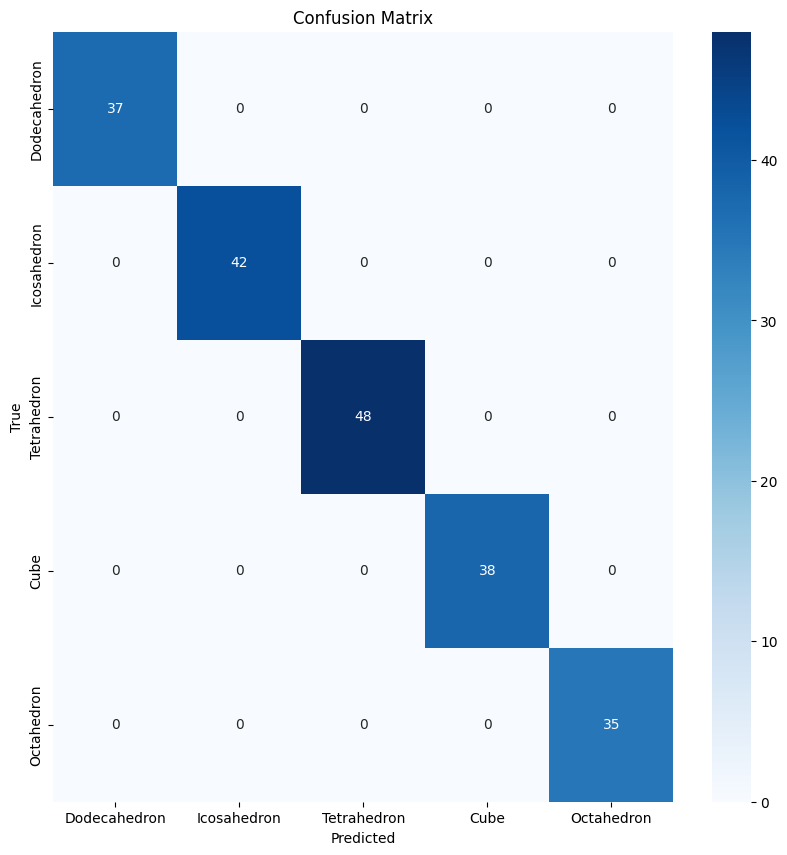

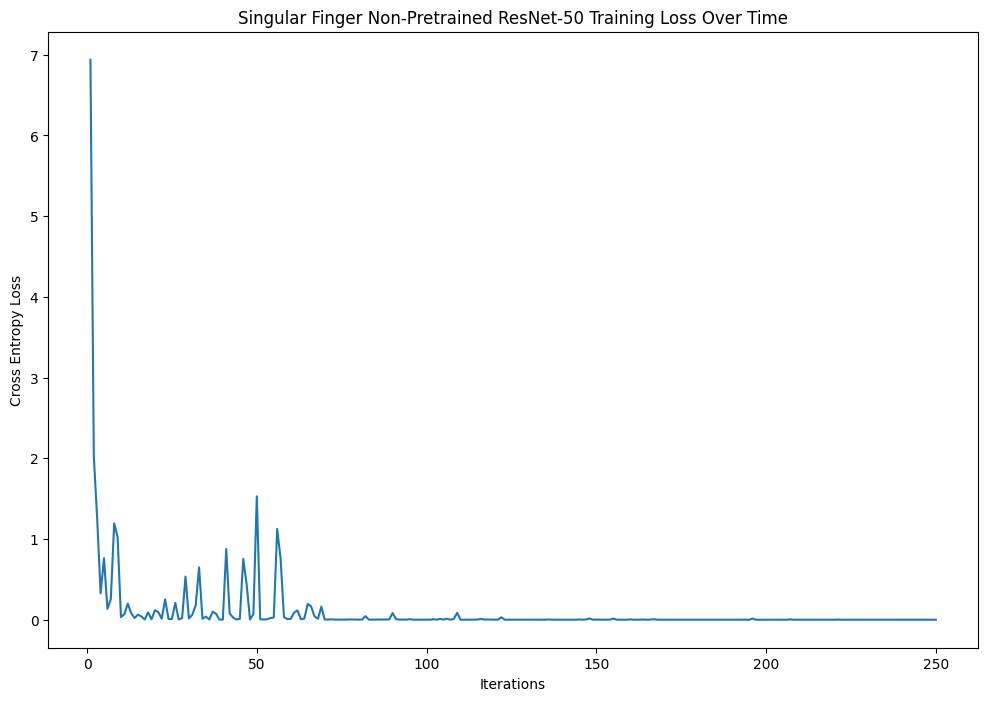

In [29]:
import torch
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

true_labels = np.load('dataset/true_labels.npy')
predicted_labels = np.load('dataset/predicted_labels.npy')
losses = np.load('dataset/predicted_losses.npy')



# CLEAN UP THIS, FROM CHAT GPT
def get_class_indices(test_loader):
    class_indices = {}
    for idx, (_, labels) in enumerate(test_loader):
        for label in labels.numpy():
            if label not in class_indices:
                class_indices[label] = idx
    return class_indices

def test_model_with_class_indices(test_loader, model):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    confusion_mat = confusion_matrix(all_labels, all_predictions)
    print('Confusion Matrix:')
    print(confusion_mat)

    class_indices = get_class_indices(test_loader)
    for label, idx in class_indices.items():
        print(f"Label {label} corresponds to row {idx} in the confusion matrix.")

    accuracy = (confusion_mat.diagonal().sum() / confusion_mat.sum()) * 100
    print('Accuracy: {}%'.format(accuracy))
    return confusion_mat

# Example usage:
# test_model_with_class_indices(test_loader, your_model)



#predicted = torch.max(predicted_tensor[0].data,1)

#print(predicted_labels)

conf_matrix = test_model_with_class_indices(test_loader, resNetNotTrained)

print(conf_matrix.shape)

plt.figure(figsize=(10,10))
# TODO: Make sure that these labels line up
platonic_solids_names = ["Dodecahedron", "Icosahedron", "Tetrahedron", "Cube", "Octahedron", ]

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=platonic_solids_names, yticklabels=platonic_solids_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()



# Plotting
plt.figure(figsize=(12,8))
plt.plot(range(1, len(losses)+1), losses)
plt.xlabel('Iterations')
plt.ylabel('Cross Entropy Loss')
plt.title('Singular Finger Non-Pretrained ResNet-50 Training Loss Over Time')
plt.show()

In [ ]:
print(X.shape)
print(y.shape)
print(len(data_train_loader))

(3680, 2048)
(3680,)
58
